<a href="https://colab.research.google.com/github/mheidari98/Movie-Recommender-Systems/blob/main/LightFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from google.colab import drive
drive.mount('/content/gdrive')

!pip install lightfm

In [ ]:
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k, reciprocal_rank
from lightfm.data import Dataset
from lightfm.datasets import fetch_movielens
from sklearn.model_selection import train_test_split
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#On 100k Dataset

In [ ]:
data = fetch_movielens(min_rating = 0.5)
data

{'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 9430 stored elements in COOrdinate format>,
 'train': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 90570 stored elements in COOrdinate format>}

In [ ]:
print(repr(data['train']))
print(repr(data['test']))


<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>
<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>


In [ ]:
model = LightFM(loss = 'warp')
model.fit(data['train'], epochs=30, num_threads=2)


In [ ]:
def sample_recommendation(model, data, user_ids):
    n_users, n_items = data['train'].shape
    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]

        #print out the results
        print("User %s" % user_id)
        print("   --Known Movies:")

        for x in known_positives[:3]:
            print("        %s" % x)

        print("   --Recommended Movies:")

        for x in top_items[:3]:
            print("        %s" % x)

sample_recommendation(model, data, [3,45,450])


User 3
   --Known Movies:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
   --Recommended Movies:
        Contact (1997)
        Air Force One (1997)
        Liar Liar (1997)
User 45
   --Known Movies:
        Twelve Monkeys (1995)
        Star Wars (1977)
        Welcome to the Dollhouse (1995)
   --Recommended Movies:
        English Patient, The (1996)
        Contact (1997)
        Scream (1996)
User 450
   --Known Movies:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
   --Recommended Movies:
        Dante's Peak (1997)
        Edge, The (1997)
        Saint, The (1997)


In [ ]:
precision = precision_at_k(model, data['test'], k=5).mean()
precision

0.119406156

In [ ]:
recall = recall_at_k(model, data['test'], k=5).mean()
recall

0.05970307529162248

In [ ]:
aucscore = auc_score(model, data['test']).mean()
aucscore

0.9091304

In [ ]:
reciprocal = reciprocal_rank(model, data['test']).mean()
reciprocal

0.26614708

#on Origin DataSet

In [ ]:
Dataset_path = "gdrive/MyDrive/Colab Notebooks/DataSet/"
Movies_metadata = pd.read_csv(Dataset_path+"MoviesInfo.csv")
ratings = pd.read_csv(Dataset_path+"CleanedRatings.csv")

In [ ]:
ratings.shape

(156849, 3)

In [ ]:
data = Dataset()
data.fit(ratings.userId.unique(), ratings.movieId.unique(),ratings.rating.unique())
interactions, weights = data.build_interactions([tuple(i) for i in ratings.values])
print(repr(interactions))

<5691x56 sparse matrix of type '<class 'numpy.int32'>'
	with 156849 stored elements in COOrdinate format>


In [ ]:
interactions.shape

(5691, 56)

In [ ]:
train,test = random_train_test_split(interactions,test_percentage=0.2,)

In [ ]:
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model = model.fit(train,
                  epochs=100,
                  num_threads=16, verbose=False)

In [ ]:
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))


Precision: train 0.66, test 0.06.


In [ ]:
train_recall = recall_at_k(model,train, k=10).mean()
test_recall = recall_at_k(model,test, k=10).mean()
print('recall: train %.2f, test %.2f.' % (train_recall, test_recall))

recall: train 0.24, test 0.12.


In [ ]:
train_aucscore = auc_score(model, train).mean()
test_aucscore = auc_score(model, test).mean()
print('auc_score: train %.2f, test %.2f.' % (train_aucscore, test_aucscore))

auc_score: train 0.63, test 0.46.


In [ ]:
train_reciprocal = reciprocal_rank(model, train).mean()
test_reciprocal = reciprocal_rank(model,test).mean()
print('reciprocal_rank: train %.2f, test %.2f.' % (train_reciprocal, test_reciprocal))

reciprocal_rank: train 0.68, test 0.19.


#compare

In [ ]:
alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)


In [ ]:
warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

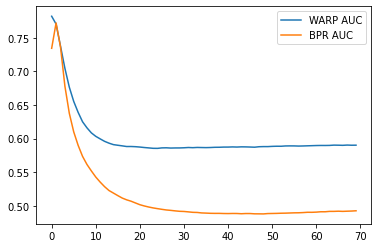

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

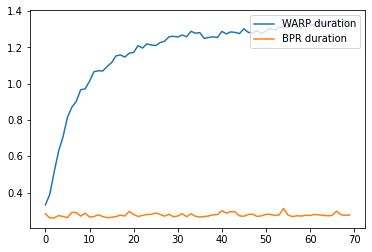

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()